# Regression task: Price Prediction: Project Summary

During the course of our project, we ran into several significant data and modeling challenges that shaped our overall approach:

## 1. Challenges We Faced

###  Challenge #1: Missing Data
One of the biggest issues we encountered was the high proportion of missing values in several important columns.  
For example:
- `cond_class`: 74.8% missing  
- `build_mat`: ~40% missing  
- `obj_type`: ~22% missing  
- `year_built`: ~16% missing  

Even structural and locational variables like `floor_no`, `infrastructure_quality`, and `has_lift` had noticeable gaps.  
This limited how much we could rely on these features and required us to develop a flexible and robust imputation strategy.

###  Challenge #2: High-Dimensional and Mixed-Type Features
The dataset included a large number of both numerical and categorical features, as well as many new interaction variables we created.  
Managing all of these in a clean and scalable way was difficult, especially when trying to prepare them for machine learning models without introducing sparsity or bias.

###  Challenge #3: Multicollinearity
After expanding the feature set with interactions (e.g., `floor_max × floor_no`, `dist_post × dist_pharma`),  
we noticed strong correlations between certain variables. This multicollinearity could have distorted model coefficients and hurt interpretability.

###  Challenge #4: Outliers in Numeric Features
We identified over **18,000 potential outliers** in the numeric data using a z-score threshold of `|z| > 3`.  
These extreme values risked skewing the results and inflating errors, so we filtered them out before training our model.

###  Challenge #5: Weak or Redundant Features
Some categorical variables—like `obj_type`—didn’t provide much extra information and were also correlated with other fields.  
We used statistical methods like **ANOVA** and **Cramér’s V** to evaluate which ones were worth keeping and avoid overfitting due to high-cardinality encoding.

###  Challenge #6: Weak Correlation with Target
Finally, we found that many raw features had only **weak individual correlation** with the target variable `price_z`.  
This meant we needed to rely more on **creative feature engineering** and interaction terms to build a stronger predictive signal.



## 2.  How We Tackled It

###  Handling Missing Values

We applied a **hybrid imputation strategy** based on missingness level and data type:

- **Dropped Extremely Sparse Columns**:  
  - Dropped `cond_class` due to >74% missing data.

- **KNN Imputation for Categorical Features**:  
  - For `build_mat` (~40%) and `obj_type` (~22%)  
  - Encoded with `OrdinalEncoder`, applied `KNNImputer (k=5)`, then decoded back.

- **KNN Imputation for Structural Variables**:  
  - For `floor_no`, `year_built`, and `infrastructure_quality`  
  - Used KNN with context features: `n_rooms`, `dim_m2`, `dist_centre`, etc.

- **Mode Imputation**:  
  - For binary/low-cardinality columns: `floor_max`, `has_lift`.

- **Mean Imputation for Continuous Distances**:  
  - For `dist_sch`, `dist_clinic`, `dist_uni`, `dist_post`, etc.  
  - These had <3% missing values and followed continuous distributions.

This approach helped preserve data while reducing risk of bias from naive imputation.


### 🔍 Feature Engineering & Variable Selection

We selected the **top 20 numeric features** most correlated with `price_z`, and from them, engineered multiple interaction features to capture complex relationships:

- `dim_m2 × n_rooms`  
- `floor_max × floor_no`  
- `dist_sch × dist_post`  
- Combinations of location-based distances, like `dist_post × dist_kind`

These new features captured contextual dependencies that helped the model better understand value influencers.



###  Categorical Variable Filtering

To avoid overfitting and reduce dimensionality:
- We used **ANOVA F-tests** to assess relationships between numeric and categorical variables.
- We used **Cramér’s V** to measure dependency between categorical features.

This helped us remove redundant variables and keep only the most informative categories.


###  Handling Outliers

We removed **over 18,000 rows** with any numeric variable where `|z-score| > 3`.  
This step stabilized our dataset and reduced noise before training.



###  Preprocessing Pipeline

We implemented a clean and consistent pipeline using `ColumnTransformer`:

- **StandardScaler** for numeric features  
- **One-Hot Encoding** for categorical features  

This ensured proper scaling and encoding across all folds of cross-validation, and helped us avoid **data leakage**.



## 3.  Why We Chose Ridge Regression

We evaluated multiple regression models before choosing Ridge as our final approach. Here's a summary of each model and why we ultimately selected Ridge:

###  Linear Regression
- **Pros**: Simple and interpretable.
- **Cons**: 
  - Very sensitive to multicollinearity and outliers.
  - Without regularization, it overfit the data due to the high dimensionality and interaction terms.
- **Result**: Lower test performance and instability in coefficients.

###  Lasso Regression
- **Pros**: Performs feature selection by shrinking some coefficients to zero.
- **Cons**: 
  - Eliminated too many weak-but-useful predictors.
  - Struggled with groups of correlated features (often picking one arbitrarily).
- **Result**: Less stable model with slightly worse performance than Ridge.

###  ElasticNet Regression
- **Pros**: Combines L1 and L2 regularization — balances between Lasso and Ridge.
- **Cons**: 
  - Performed well, but required careful tuning of two hyperparameters (`alpha` and `l1_ratio`).
  - Final performance was close to Ridge, but added complexity.
- **Result**: Good candidate, but Ridge was more stable and interpretable with similar accuracy.

###  K-Nearest Neighbors Regression (KNN)
- **Pros**: Non-parametric, no need for assumptions on data distribution.
- **Cons**: 
  - Computationally expensive with large datasets.
  - Sensitive to irrelevant features and feature scaling.
  - Struggled with high dimensionality and sparse data after encoding.
- **Result**: Lower R² and higher RMSE, especially on unseen data.



###  Why Ridge Regression Won

We chose **Ridge Regression** as our final model due to its:

- **Robust handling of multicollinearity** via L2 regularization.
- **Retention of all features**, including those weakly correlated with the target, which helped with generalization.
- **Ease of tuning**: only one hyperparameter (`alpha`), which we optimized using cross-validation.
- **Strong performance** on test data:
  - **R²**: 0.95  
  - **RMSE**: ≈ 97,873  
  - **MAPE**: ≈ 9.3%

We also appreciated Ridge's **interpretability**, which is important in real-world housing applications where model transparency matters.






In [1]:
# Import all the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_predict, KFold,cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge,Lasso,LassoCV
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    median_absolute_error, 
    r2_score,
    confusion_matrix, 
    roc_curve, 
    auc, 
    classification_report
)

from sklearn.pipeline import Pipeline
from scipy.stats import skew,zscore
from sklearn.impute import KNNImputer
from statsmodels.stats.anova import anova_lm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder




              dim_m2        n_rooms       floor_no      floor_max  \
count  156454.000000  156454.000000  128756.000000  154533.000000   
mean       58.702447       2.678634       3.334749       5.312859   
std        23.278725       0.916015       2.535675       3.311659   
min        18.780000       1.000000       1.000000       1.000000   
25%        42.240000       2.000000       2.000000       3.000000   
50%        54.240000       3.000000       3.000000       4.000000   
75%        69.820000       3.000000       4.000000       6.000000   
max       187.310000       6.000000      29.000000      29.000000   

          year_built    dist_centre          n_poi       dist_sch  \
count  130741.000000  156454.000000  156454.000000  156324.000000   
mean     1986.010532       4.357027      20.611509       0.413302   
std        33.792722       2.900580      24.212745       0.469380   
min      1850.000000       0.008000       0.000000       0.002000   
25%      1967.000000       2.0000

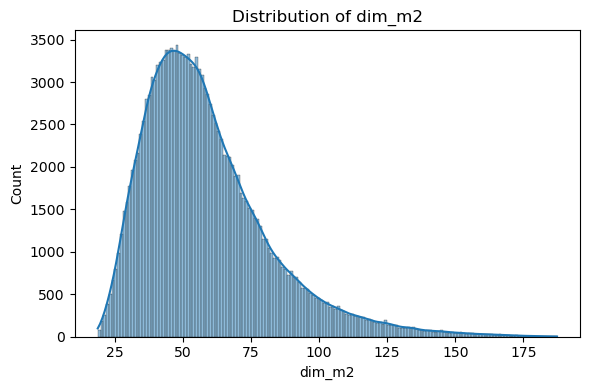

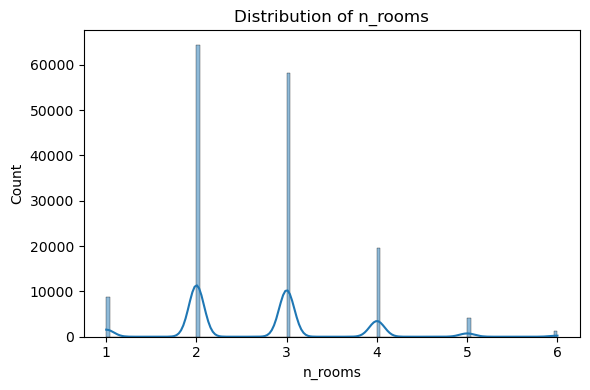

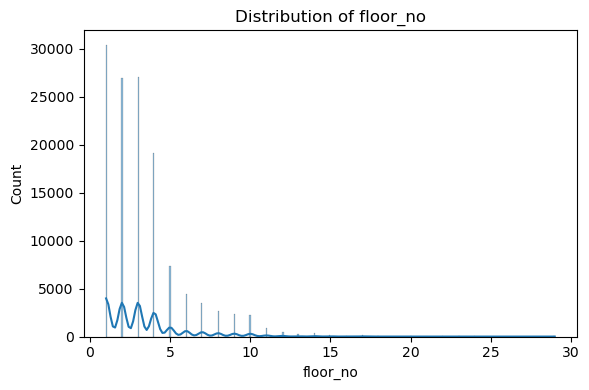

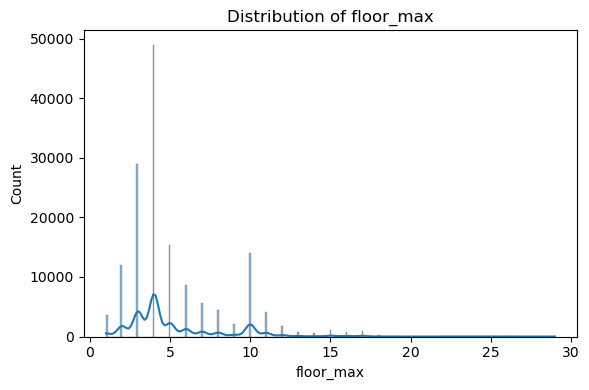

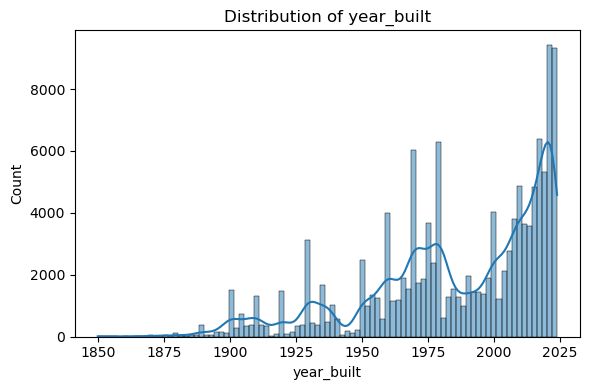

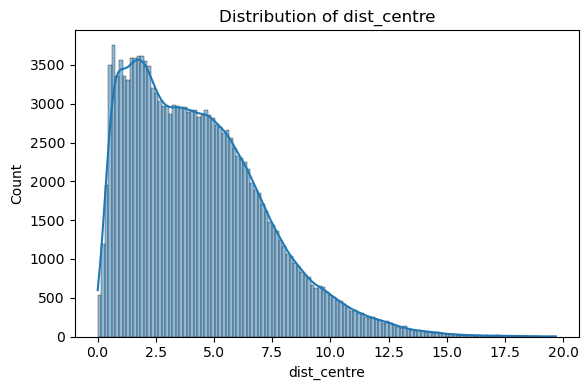

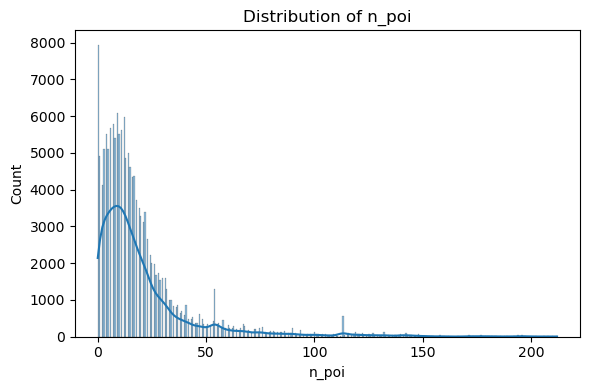

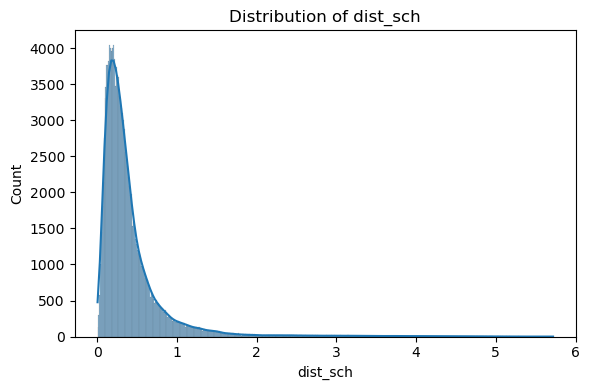

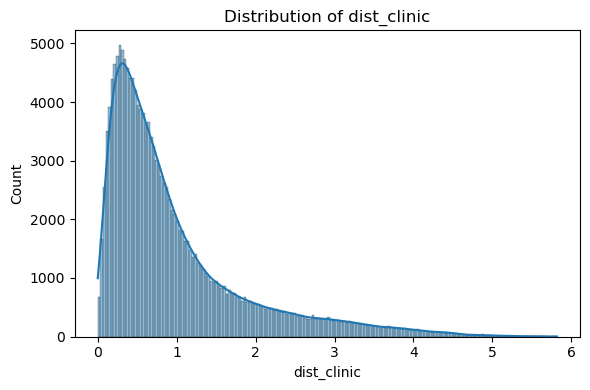

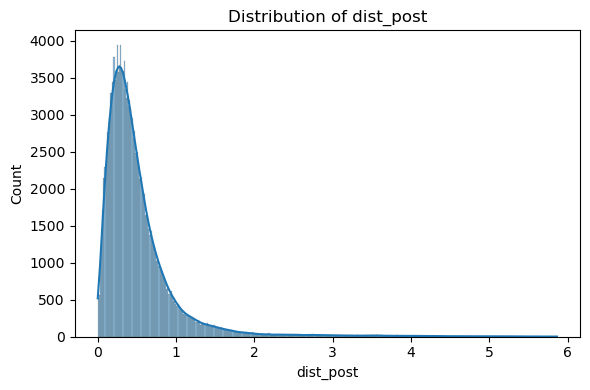

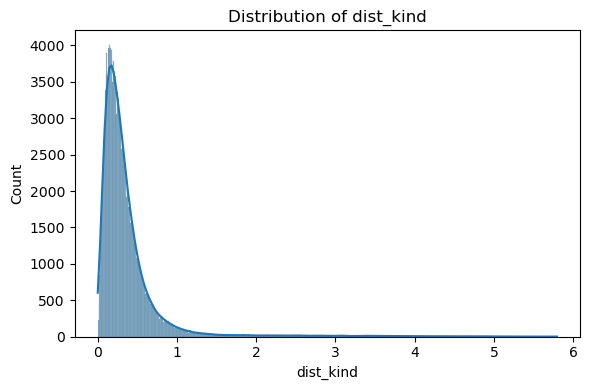

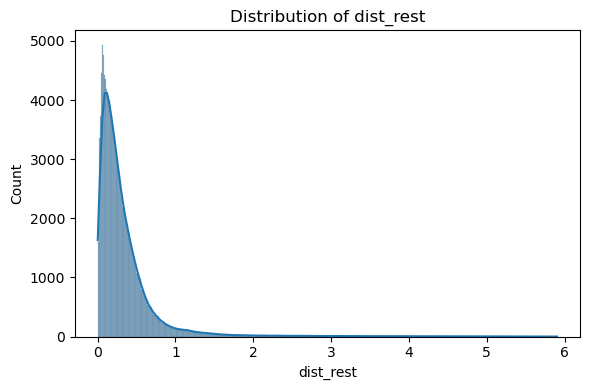

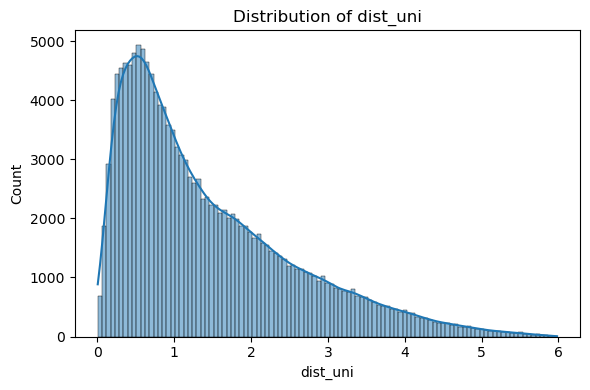

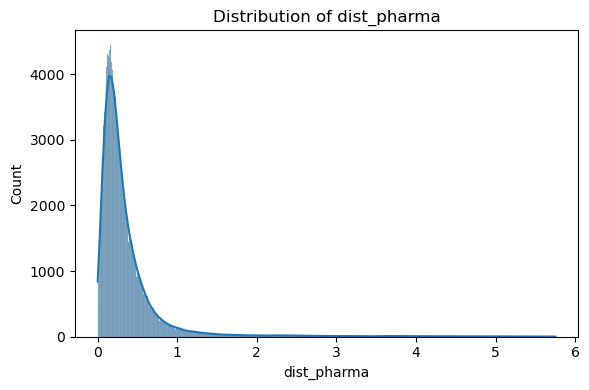

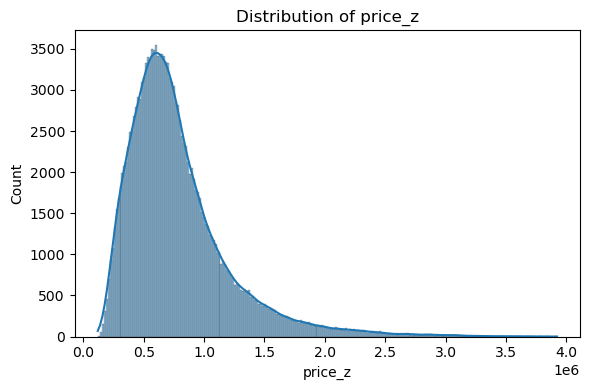

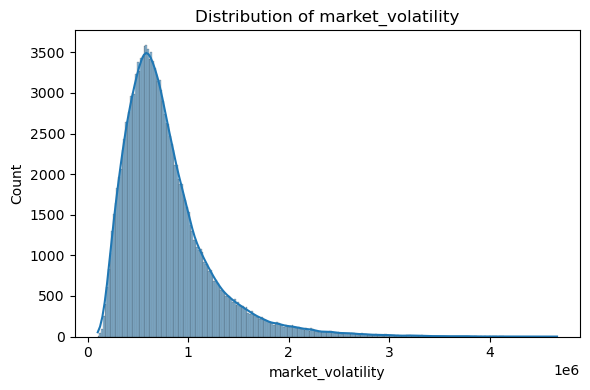

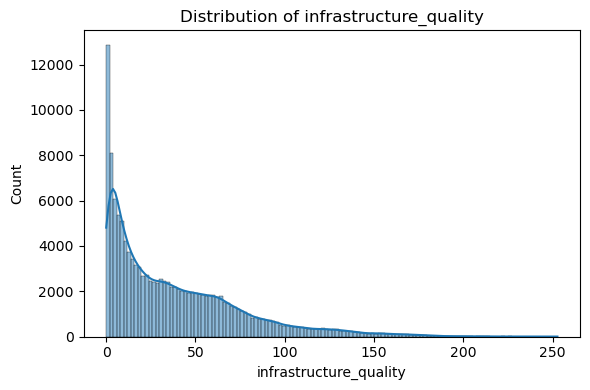

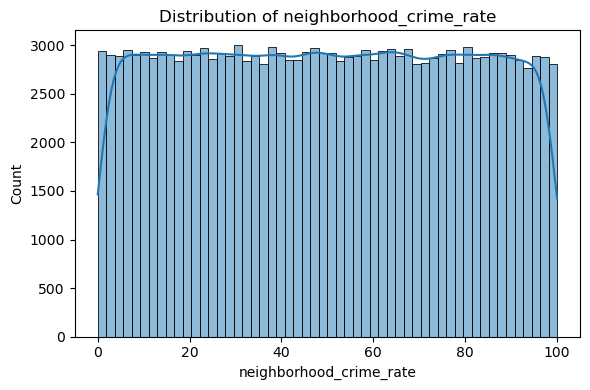

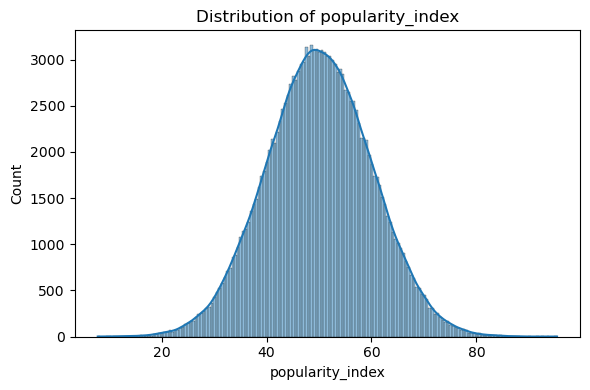

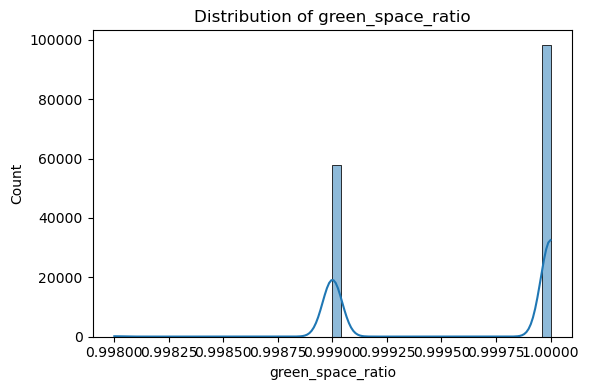

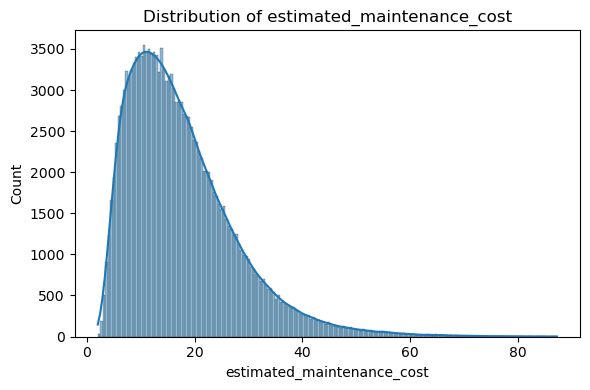

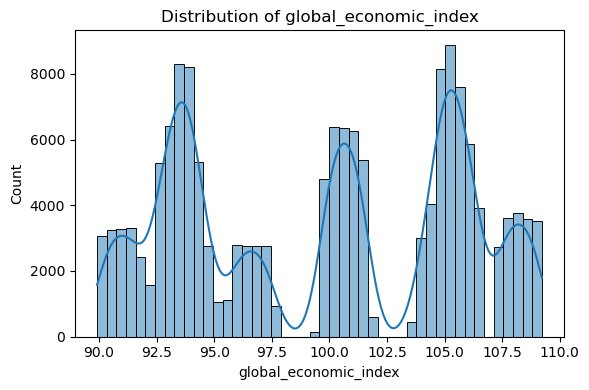

Skipping unit_id: too many unique values (82491)


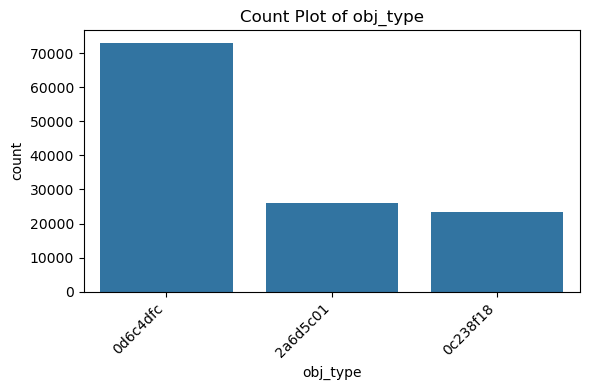

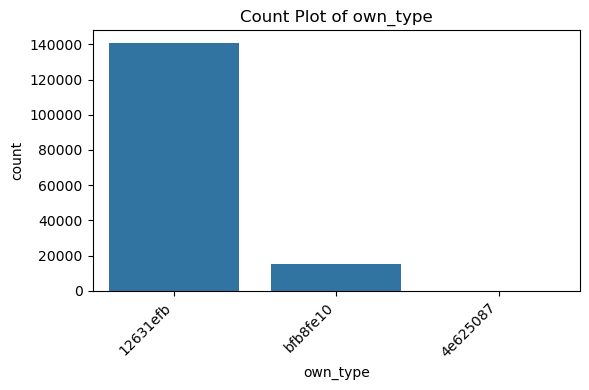

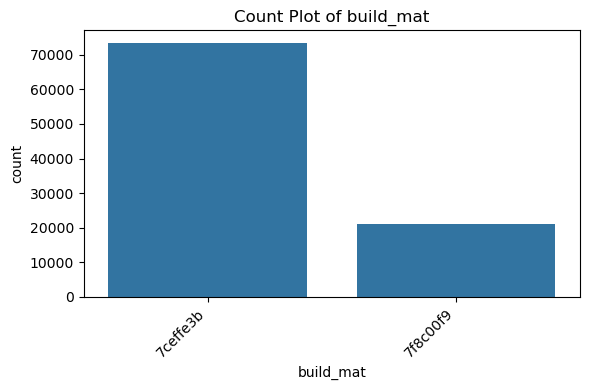

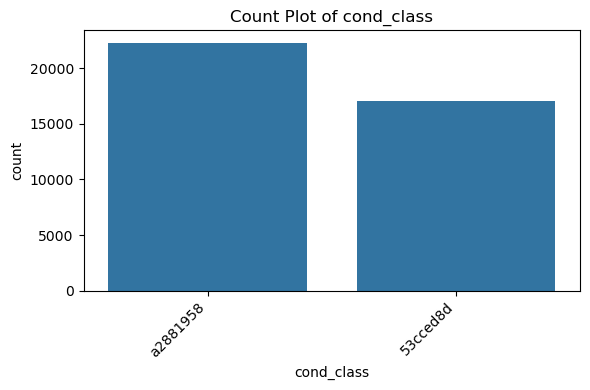

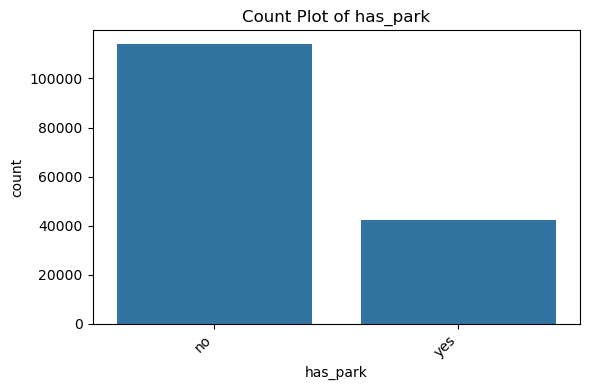

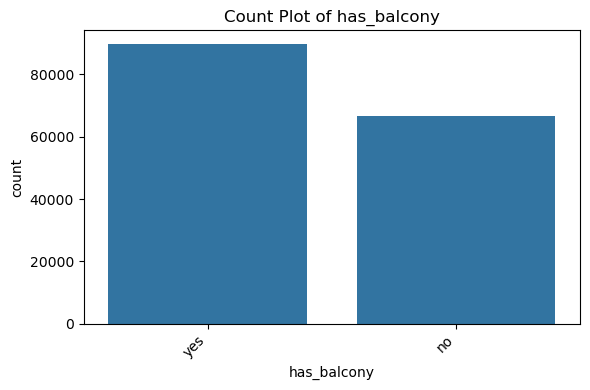

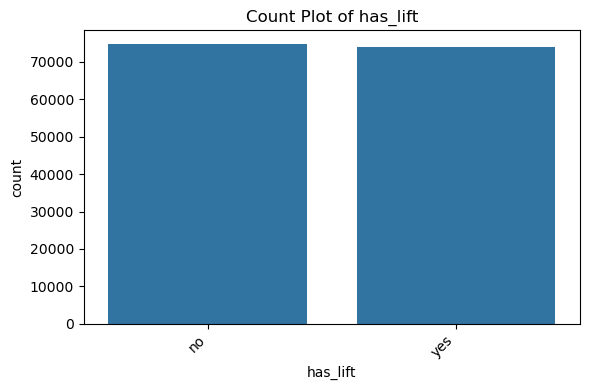

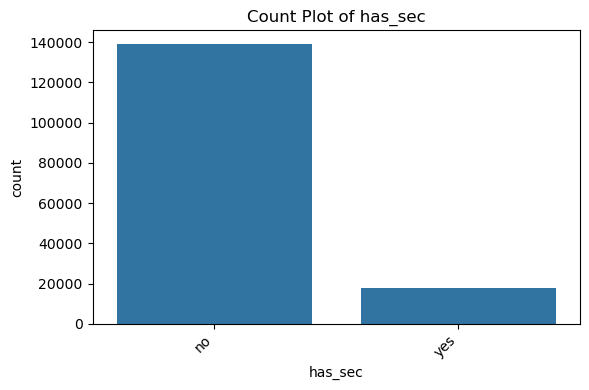

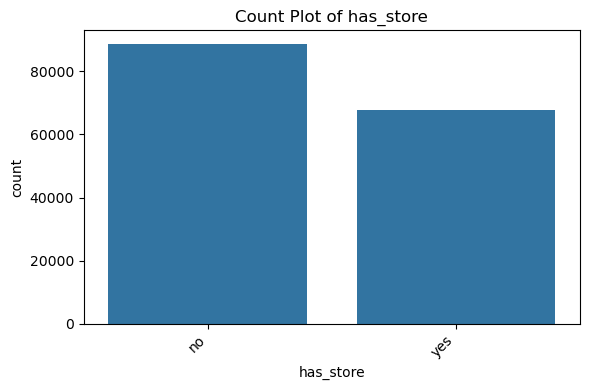

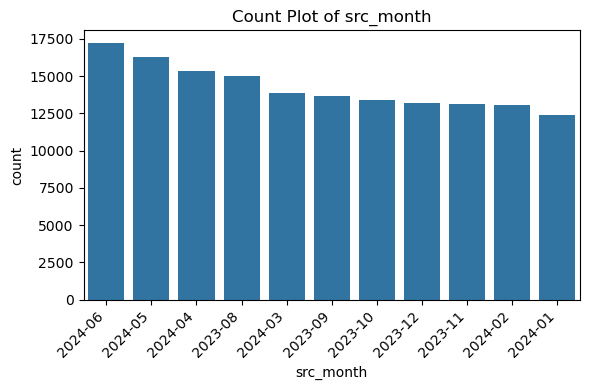

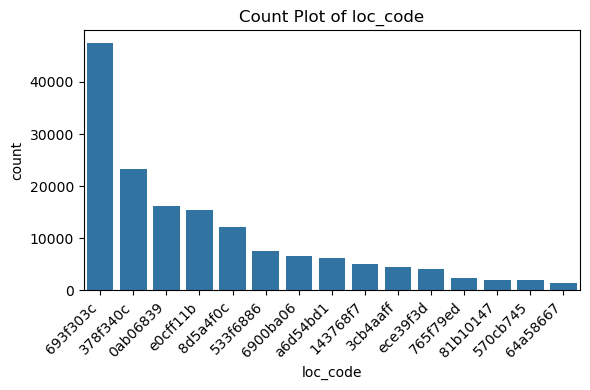

In [2]:
# Import data
data = pd.read_csv("/Users/phuongtrang/Documents/Study/2nd semester/ML/Data/appartments_train.csv")
data_test_final = pd.read_csv("/Users/phuongtrang/Documents/Study/2nd semester/ML/Data/appartments_test.csv")
data_test_prediction=data_test_final.copy()
# Data summary
print(data.describe())
print(data.info())

# Missing Value Analysis
missing_data = data.isnull().sum() / len(data) * 100
missing_data = missing_data[missing_data > 0]
missing_data = missing_data.sort_values(ascending=False)
print("Missing values % in each column:")
print(missing_data)

# Checking distribution of numerical data

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Checking distribution of categorical data

categorical_vars = data.select_dtypes(include=['object', 'category']).columns
for col in categorical_vars:
    if data[col].nunique(dropna=False) > 50:
        print(f"Skipping {col}: too many unique values ({data[col].nunique()})")
        continue

    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=data, order=data[col].value_counts().index)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Count Plot of {col}')
    plt.tight_layout()
    plt.show()

# Handling missing data
# With > 50% missing data, we will remove the variable: cond_class 74.8% NA
# Replace with "KNN" value - build_mat (39% NA), obj_type (22% NA),
# Replace with "Most" value - floor_no (18% NA), year_built (16% NA), floor_max (1%), has_lift (5% NA)
# Replace with "Mean" value - dist_sch (0.08% NA), dist_clinic (0.36% NA), dist_post (0.12%NA), dist_kind (0.1% NA), dist_rest (0.2% NA),
# dist_uni (2.7% NA), dist_pharma (0.1% NA),infrastructure_quality (16%)

# 1. Drop 'cond_class'
data.drop(columns=['cond_class'], inplace=True)
data_test_final.drop(columns=['cond_class'], inplace=True)

# 2. Replace with "KNN" value

# Encode categoricals
encoder = OrdinalEncoder()
data_encoded = data[['build_mat', 'obj_type']].copy()
data_test_encoded = data_test_final[['build_mat', 'obj_type']].copy()

data_encoded = encoder.fit_transform(data_encoded)
data_test_encoded = encoder.transform(data_test_encoded)

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
data_encoded = imputer.fit_transform(data_encoded)
data_test_encoded = imputer.transform(data_test_encoded)

# Decode back to original labels
data[['build_mat', 'obj_type']] = encoder.inverse_transform(data_encoded)
data_test_final[['build_mat', 'obj_type']] = encoder.inverse_transform(data_test_encoded)


knn_impute_cols = ['floor_no', 'year_built', 'infrastructure_quality']
knn_context_cols = knn_impute_cols + ['n_rooms', 'dim_m2', 'floor_max', 'dist_centre', 'market_volatility']

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[knn_context_cols])
test_scaled = scaler.transform(data_test_final[knn_context_cols])

imputer_knn = KNNImputer(n_neighbors=5)
data_imputed = imputer_knn.fit_transform(data_scaled)
test_imputed = imputer_knn.transform(test_scaled)

data[knn_impute_cols] = pd.DataFrame(data_imputed, columns=knn_context_cols, index=data.index)[knn_impute_cols]
data_test_final[knn_impute_cols] = pd.DataFrame(test_imputed, columns=knn_context_cols, index=data_test_final.index)[knn_impute_cols]
# 3. Fill with mode (most frequent value)
fill_mode_cols = ['floor_max', 'has_lift']
for col in fill_mode_cols:
    mode_val = data[col].mode()[0]
    mode_val_test_final = data_test_final[col].mode()[0]
    data[col] = data[col].fillna(mode_val)
    data_test_final[col] = data_test_final[col].fillna(mode_val_test_final)

# 4. Fill with mean for numerical distances
fill_mean_cols = ['dist_sch', 'dist_clinic', 'dist_post', 'dist_kind',
                  'dist_rest', 'dist_uni', 'dist_pharma']
for col in fill_mean_cols:
    mean_val = data[col].mean()
    mean_val_test_final = data_test_final[col].mean()
    data[col] = data[col].fillna(mean_val)
    data_test_final[col] = data_test_final[col].fillna(mean_val_test_final)

# Convert 'src_month' to numerical format
data['src_month'] = pd.to_datetime(data['src_month'], format='%Y-%m')
data_test_final['src_month'] = pd.to_datetime(data_test_final['src_month'], format='%Y-%m')
data['src_month_year'] = data['src_month'].dt.year
data['src_month_month'] = data['src_month'].dt.month
data = data.drop(columns=['src_month'])

data_test_final['src_month_year'] = data_test_final['src_month'].dt.year
data_test_final['src_month_month'] = data_test_final['src_month'].dt.month
data_test_final = data_test_final.drop(columns=['src_month'])

# Drop the 'unit_id' column
data.drop(columns=['unit_id'], inplace=True)
data_test_final.drop(columns=['unit_id'], inplace=True)


# Slpit train dataset into 2 (train and test sets)

data_train, data_test = train_test_split(
    data, test_size=0.2, random_state=42
)

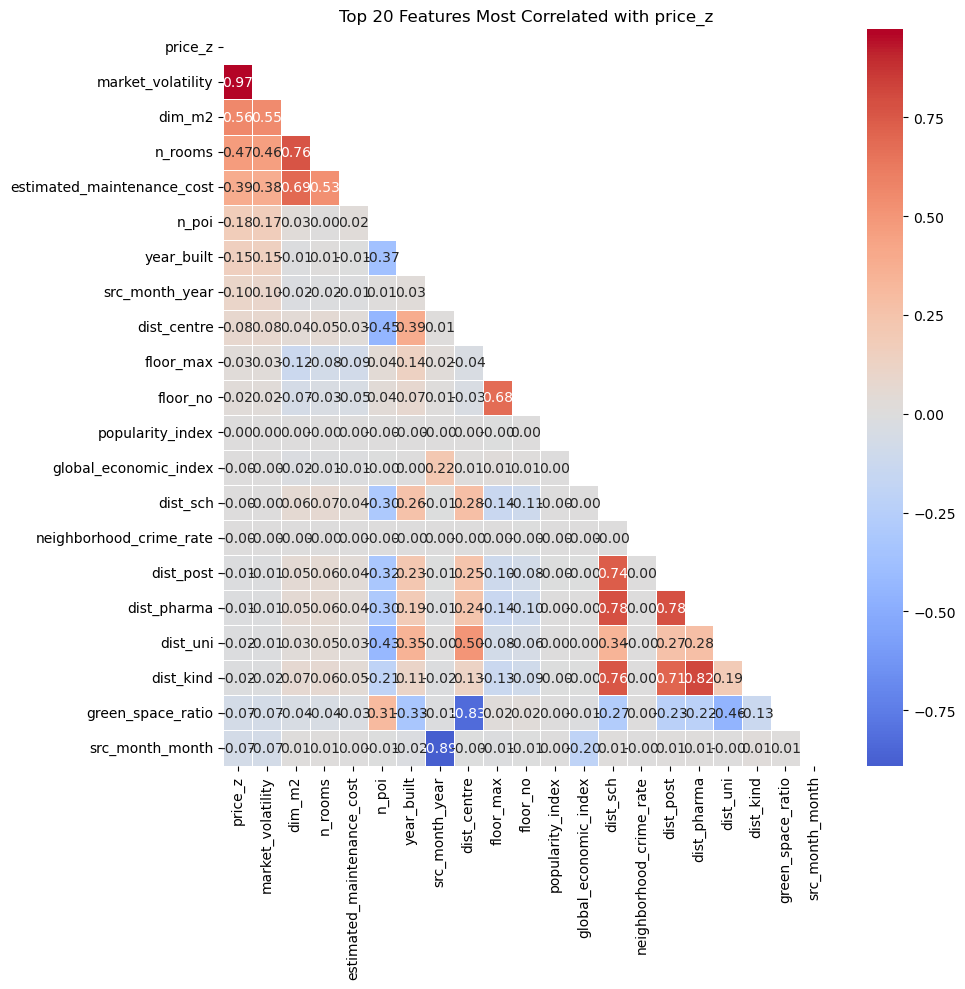

In [3]:
# Compute the correlation matrix from data_train_encoded (only numeric variables)
data_numeric_columns = data_train.select_dtypes(include=[np.number])
corr_matrix = data_numeric_columns.corr()

# Compute correlation with the target variable 'price_z' and sort
correlation_with_target = corr_matrix['price_z'].sort_values(ascending=False)
ordered_cols = correlation_with_target.index

# Reorder the correlation matrix based on relevance to 'price_z'
corr_matrix_ordered = corr_matrix[ordered_cols].loc[ordered_cols]

# Select the 20 features most strongly correlated with 'price_z'
top_features = correlation_with_target.index[:21]

# Create a submatrix from the ordered correlation matrix for those top features
top_corr_matrix = corr_matrix_ordered.loc[top_features, top_features]

# Create a mask for the upper triangle of the submatrix
top_mask = np.triu(np.ones_like(top_corr_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(top_corr_matrix,
            annot=True,
            mask=top_mask,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5,
            center=0)

plt.title("Top 20 Features Most Correlated with price_z")
plt.tight_layout()
plt.show()


In [5]:
# Exclude 'price_z' from top features
top_features_no_target = [f for f in top_features if f != 'price_z']

# Select strong interaction candidates (absolute corr > 0.6 and not self-correlation)
interaction_pairs = []
threshold = 0.6

for i in range(len(top_features_no_target)):
    for j in range(i+1, len(top_features_no_target)):
        f1, f2 = top_features_no_target[i], top_features_no_target[j]
        corr_val = top_corr_matrix.loc[f1, f2]
        if abs(corr_val) > threshold:
            interaction_pairs.append((f1, f2))

print("✅ Selected interaction pairs:")
for f1, f2 in interaction_pairs:
    print(f"{f1} x {f2} (corr = {top_corr_matrix.loc[f1, f2]:.2f})")

# Add interaction features to both training and test data
for f1, f2 in interaction_pairs:
    inter_col = f"{f1}_x_{f2}"
    data_train[inter_col] = data_train[f1] * data_train[f2]
    data_test[inter_col] = data_test[f1] * data_test[f2]
    data_test_final[inter_col] = data_test_final[f1] * data_test_final[f2]


✅ Selected interaction pairs:
dim_m2 x n_rooms (corr = 0.76)
dim_m2 x estimated_maintenance_cost (corr = 0.69)
src_month_year x src_month_month (corr = -0.89)
dist_centre x green_space_ratio (corr = -0.83)
floor_max x floor_no (corr = 0.68)
dist_sch x dist_post (corr = 0.74)
dist_sch x dist_pharma (corr = 0.78)
dist_sch x dist_kind (corr = 0.76)
dist_post x dist_pharma (corr = 0.78)
dist_post x dist_kind (corr = 0.71)
dist_pharma x dist_kind (corr = 0.82)


In [6]:
# 1. Identify all base variables used in interaction terms
vars_in_interactions = set()
for f1, f2 in interaction_pairs:
    vars_in_interactions.update([f1, f2])

# 2. Create list of columns to drop
columns_to_drop = list(vars_in_interactions)

# 3. Drop those columns from both train and test datasets
data_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')
data_train.drop(columns=columns_to_drop, inplace=True, errors='ignore')
data_test_final.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print("✅ Removed base variables used in interaction terms:")
print(columns_to_drop)


✅ Removed base variables used in interaction terms:
['floor_no', 'dist_post', 'dist_kind', 'dim_m2', 'dist_centre', 'floor_max', 'estimated_maintenance_cost', 'n_rooms', 'src_month_month', 'dist_pharma', 'src_month_year', 'dist_sch', 'green_space_ratio']


In [7]:
data_categorical_variables = data_train.select_dtypes("object").columns
print(data_categorical_variables)

Index(['obj_type', 'own_type', 'build_mat', 'has_park', 'has_balcony',
       'has_lift', 'has_sec', 'has_store', 'loc_code'],
      dtype='object')


In [9]:
# let's write a function that retrieves this value for selected
# categorical variables in their relation with a dependent variable
# and a dataset - provided as function arguments

def anova_for_categorical_vars(dataset, dep_var, cat_vars):
    # Initialize a list to store the results
    results = []

    # Loop through each categorical variable
    for var in cat_vars:
        # Fit the ANOVA model (Ordinary Least Squares regression)
        model = smf.ols(f'{dep_var} ~ C({var})', data = dataset).fit()

        # Perform ANOVA on the fitted model
        anova_table = anova_lm(model)

        # Extract the F-statistic and p-value from the ANOVA table
        f_statistic = anova_table['F'].iloc[0]  # First row in the F column
        p_value = anova_table['PR(>F)'].iloc[0]  # First row in the p-value column

        # Append the results to the list
        results.append([var, f_statistic, p_value])

    # Create a DataFrame with the results
    anova_results_df = pd.DataFrame(results,
                                    columns = ['Variable', 'F-statistic', 'p-value'])

    # Sort the DataFrame by F-statistic in decreasing order
    anova_results_df = anova_results_df.sort_values(by = 'F-statistic',
                                                    ascending = False)

    # Return the sorted DataFrame
    return anova_results_df


In [16]:

# and apply it to our data
anova_results = anova_for_categorical_vars(data_train,
                                                  'price_z',
                                                  data_categorical_variables)

# Display the result
print(anova_results)

      Variable  F-statistic        p-value
2    build_mat  5773.840845   0.000000e+00
0     obj_type  5125.797342   0.000000e+00
5     has_lift  5077.149503   0.000000e+00
7    has_store  3321.287730   0.000000e+00
8     loc_code  3219.617783   0.000000e+00
6      has_sec  2362.623929   0.000000e+00
3     has_park  2231.477909   0.000000e+00
1     own_type   725.174348  7.439744e-314
4  has_balcony   592.833589  1.223225e-130


In [17]:
# lets check mutual relationships between categorical predictors

def cramers_v(contingency_table):
    """Calculate Cramér's V statistic from a contingency table."""
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

def calculate_cramers_v_matrix(dataset, cat_vars):
    """Calculate the Cramér's V for each pair of categorical variables."""
    # Create an empty matrix to store the results
    cramers_v_matrix = pd.DataFrame(np.zeros((len(cat_vars), len(cat_vars))),
                                    columns = cat_vars,
                                    index = cat_vars)

    # Loop through each pair of categorical variables
    for i in range(len(cat_vars)):
        for j in range(i, len(cat_vars)):  # to avoid recalculating for the same pair
            var_1 = cat_vars[i]
            var_2 = cat_vars[j]

            # Create a contingency table for the two variables
            contingency_table = pd.crosstab(dataset[var_1], dataset[var_2])

            # Calculate Cramér's V
            cramers_v_value = cramers_v(contingency_table)

            # Store the result in the matrix
            cramers_v_matrix.loc[var_1, var_2] = cramers_v_value
            cramers_v_matrix.loc[var_2, var_1] = cramers_v_value  # Symmetric matrix

    return cramers_v_matrix
from scipy.stats import chi2_contingency
# and apply the analysis to our data
cramers_v_matrix_result = calculate_cramers_v_matrix(data_train, data_categorical_variables)

cramers_v_matrix_result.head()

,obj_type,own_type,build_mat,has_park,has_balcony,has_lift,has_sec,has_store,loc_code
obj_type,1.000000,0.131313,0.259530,0.214446,0.265698,0.414977,0.192015,0.260068,0.149708
own_type,0.131313,1.000000,0.288642,0.000387,0.051638,0.010600,0.077873,0.165871,0.125567
build_mat,0.259530,0.288642,0.999966,0.070877,0.069965,0.068062,0.109832,0.225448,0.205161
has_park,0.214446,0.000387,0.070877,0.999980,0.085196,0.137638,0.080649,0.035271,0.186049
has_balcony,0.265698,0.051638,0.069965,0.085196,0.999984,0.147584,0.065928,0.092581,0.116809


<Axes: >

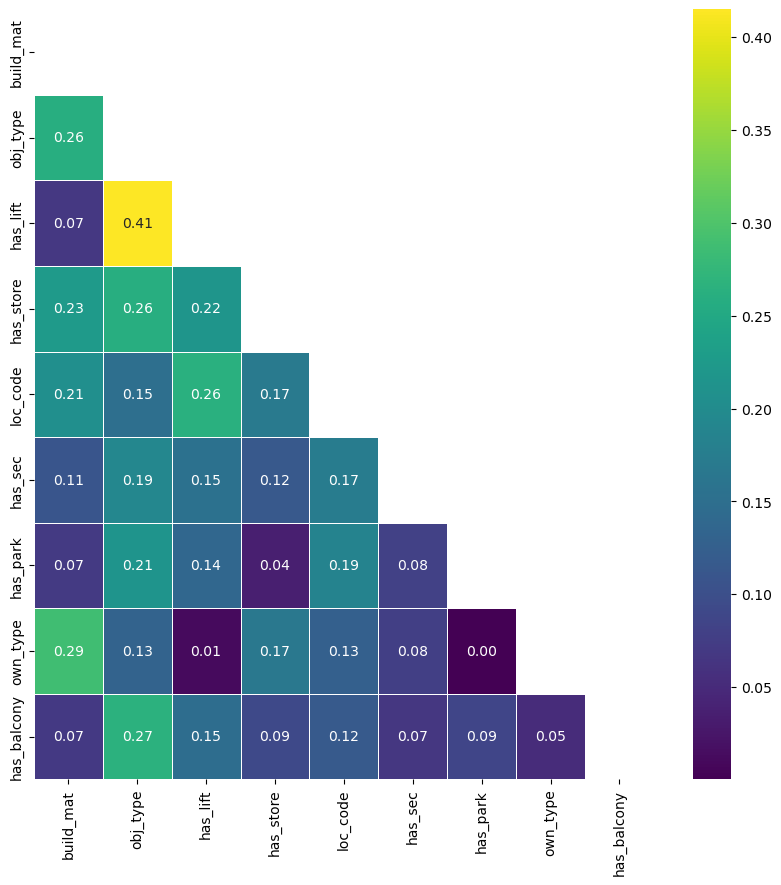

In [18]:

variables_order = anova_results["Variable"].tolist()
cramers_v_matrix = cramers_v_matrix_result[variables_order].loc[variables_order]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cramers_v_matrix, dtype = bool))

plt.figure(figsize=(10, 10))

sns.heatmap(cramers_v_matrix,
            annot = True,
            cmap = "viridis",
            fmt = ".2f",
            mask = mask,
            linewidths = 0.5)

In [19]:
data_train.drop(columns=['obj_type'],inplace=True)
data_test.drop(columns=['obj_type'],inplace=True)
data_test_final.drop(columns=['obj_type'],inplace=True)

In [20]:
# Select only numeric features (excluding target)
numeric_features = data_train.select_dtypes(include=[np.number]).drop(columns=['price_z'])

# Compute z-scores only for numeric features
z_scores = np.abs(zscore(numeric_features))

# Define outliers: any z-score > 3 across any feature
outliers = (z_scores > 3).any(axis=1)

# Print number of detected outliers
print("Number of potential outliers:", outliers.sum())

# Define features and target variable, excluding outliers
X = data_train.drop(columns='price_z')[~outliers]
y = data_train['price_z'][~outliers]
X_test = data_test.drop(columns='price_z')
y_test = data_test['price_z']


Number of potential outliers: 18043


In [21]:
data_train.columns

Index(['year_built', 'n_poi', 'dist_clinic', 'dist_rest', 'dist_uni',
       'own_type', 'build_mat', 'has_park', 'has_balcony', 'has_lift',
       'has_sec', 'has_store', 'price_z', 'loc_code', 'market_volatility',
       'infrastructure_quality', 'neighborhood_crime_rate', 'popularity_index',
       'global_economic_index', 'dim_m2_x_n_rooms',
       'dim_m2_x_estimated_maintenance_cost',
       'src_month_year_x_src_month_month', 'dist_centre_x_green_space_ratio',
       'floor_max_x_floor_no', 'dist_sch_x_dist_post',
       'dist_sch_x_dist_pharma', 'dist_sch_x_dist_kind',
       'dist_post_x_dist_pharma', 'dist_post_x_dist_kind',
       'dist_pharma_x_dist_kind'],
      dtype='object')

In [48]:
# --- Define regression metrics ---
def regression_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'R2': r2_score(y_true, y_pred)
    }

# --- Updated variable lists ---
numeric_vars = [
    'year_built', 'n_poi', 'dist_clinic', 'dist_rest', 'dist_uni',
    'market_volatility', 'infrastructure_quality', 'neighborhood_crime_rate',
    'popularity_index', 'global_economic_index',
    'dim_m2_x_n_rooms', 'dim_m2_x_estimated_maintenance_cost',
    'src_month_year_x_src_month_month', 'dist_centre_x_green_space_ratio',
    'floor_max_x_floor_no', 'dist_sch_x_dist_post',
    'dist_sch_x_dist_pharma', 'dist_sch_x_dist_kind',
    'dist_post_x_dist_pharma', 'dist_post_x_dist_kind',
    'dist_pharma_x_dist_kind'
]

categorical_vars = [
    'own_type', 'build_mat', 'has_park', 'has_balcony',
    'has_lift', 'has_sec', 'has_store', 'loc_code'
]

# --- Ridge model evaluation ---
def evaluate_ridge_model(X, y):
    # Preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_vars)
    ])

    # Pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('ridge', Ridge())
    ])

    # Grid search over alpha
    params = {'ridge__alpha': np.logspace(-4, 4, 20)}
    cv5 = KFold(n_splits=5, shuffle=True, random_state=123)

    grid = GridSearchCV(
        pipeline, param_grid=params,
        scoring='neg_root_mean_squared_error',
        cv=cv5, n_jobs=-1
    )

    # Fit model
    grid.fit(X, y)

    # Evaluate on training data
    best_model = grid.best_estimator_
    metrics = regression_metrics(y, best_model.predict(X))
    metrics['Alpha'] = best_model.named_steps['ridge'].alpha
    metrics['Model'] = 'Ridge'

    return metrics, best_model
metrics, best_ridge_model = evaluate_ridge_model(X, y)
print(pd.Series(metrics))

RMSE     87540.001266
MAE      66764.022697
MedAE    53940.041363
MAPE         9.183816
R2           0.935943
Alpha       11.288379
Model           Ridge
dtype: object


In [34]:
# Appy model on test data

test_preds = best_ridge_model.predict(X_test)
test_metrics = regression_metrics(y_test, test_preds)

print("Testing performance:", test_metrics)

Testing performance: {'RMSE': 97873.34676196246, 'MAE': 72403.05722511827, 'MedAE': 56448.16206688667, 'MAPE': 9.302987849531933, 'R2': 0.9496637164407008}


In [63]:
# transform the nominal variables
nominal_variable =  [
    'own_type', 'build_mat', 'has_park', 'has_balcony',
    'has_lift', 'has_sec', 'has_store', 'loc_code'
]

# and one-hot-encoding using the pandas get_dummies()
# train
data_train_encoded = pd.get_dummies(data_train,
                                      columns = nominal_variable,
                                      drop_first = True,
                                      dtype = int) # bool by default

# test
data_test_encoded = pd.get_dummies(data_test,
                                     columns = nominal_variable,
                                     drop_first = True,
                                     dtype = int)

data_test_encoded.head()

,year_built,n_poi,dist_clinic,dist_rest,dist_uni,price_z,market_volatility,infrastructure_quality,neighborhood_crime_rate,popularity_index,...,loc_code_570cb745,loc_code_64a58667,loc_code_6900ba06,loc_code_693f303c,loc_code_765f79ed,loc_code_81b10147,loc_code_8d5a4f0c,loc_code_a6d54bd1,loc_code_e0cff11b,loc_code_ece39f3d
62171,-0.219295,23.0,0.909,0.287,0.116,460197.38,503302.80,0.324481,34.25,62.03,...,0,0,0,0,0,0,0,1,0,0
12494,-1.402986,38.0,0.281,0.371,0.060,652758.54,532365.70,1.308398,48.82,44.38,...,0,0,0,0,0,0,0,0,0,0
21885,1.065011,16.0,0.268,0.209,1.235,763524.27,711900.28,-0.952784,59.83,50.81,...,0,0,0,1,0,0,0,0,0,0
142343,1.124195,29.0,1.305,0.214,0.705,1266296.70,1306800.91,-1.029525,62.37,73.27,...,0,0,1,0,0,0,0,0,0,0
63316,-0.177865,22.0,0.368,0.132,2.145,246145.72,221909.30,0.663118,37.52,41.75,...,1,0,0,0,0,0,0,0,0,0


In [64]:
X = data_train_encoded.drop('price_z', axis = 1)
y = data_train_encoded['price_z']

# Test data for prediction
X_test = data_test_encoded.drop('price_z', axis = 1)
y_test = data_test_encoded['price_z']


In [65]:
def regression_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'R2': r2_score(y_true, y_pred)
    }



In [66]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=123)

models = {
    'Linear': Pipeline([
        ('regressor', LinearRegression())
    ]),

    'Ridge': GridSearchCV(
        Pipeline([
            ('regressor', Ridge())
        ]),
        param_grid={'regressor__alpha': np.logspace(-4, 4, 20)},
        scoring='neg_root_mean_squared_error',
        cv=cv5,
        n_jobs=-1
    ),

    'Lasso': GridSearchCV(
        Pipeline([
            ('regressor', Lasso(max_iter=10000))
        ]),
        param_grid={'regressor__alpha': np.logspace(-4, 1, 20)},
        scoring='neg_root_mean_squared_error',
        cv=cv5,
        n_jobs=-1
    ),

    'KNN': GridSearchCV(
        Pipeline([
            ('regressor', KNeighborsRegressor())
        ]),
        param_grid={'regressor__n_neighbors': list(range(3, 20))},
        scoring='neg_root_mean_squared_error',
        cv=cv5,
        n_jobs=-1
    ),

    'ElasticNet': GridSearchCV(
        Pipeline([
            ('regressor', ElasticNet(max_iter=10000))
        ]),
        param_grid={
            'regressor__alpha': np.logspace(-4, 1, 10),
            'regressor__l1_ratio': np.linspace(0.1, 0.9, 5)
        },
        scoring='neg_root_mean_squared_error',
        cv=cv5,
        n_jobs=-1
    )
}


In [67]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X, y)

    if isinstance(model, GridSearchCV):
        best_model = model.best_estimator_
        param_value = model.best_params_
    else:
        best_model = model
        param_value = {}

    # Train metrics
    y_pred_train = best_model.predict(X)
    train_metrics = regression_metrics(y, y_pred_train)
    train_metrics['Model'] = name
    train_metrics.update(param_value)

    # Test metrics
    y_pred_test = best_model.predict(X_test)
    test_metrics = regression_metrics(y_test, y_pred_test)
    test_metrics = {f"test_{k}": v for k, v in test_metrics.items()}

    train_metrics.update(test_metrics)
    results.append(train_metrics)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
print(comparison_df[['Model', 'RMSE', 'test_RMSE', 'R2', 'test_R2'] + [col for col in comparison_df.columns if 'regressor__' in col]])


Training Linear...
Training Ridge...
Training Lasso...
Training KNN...
Training ElasticNet...
        Model          RMSE      test_RMSE        R2   test_R2  \
0      Linear  95908.114695   97182.036028  0.949934  0.950372   
1       Ridge  95908.156984   97182.432831  0.949934  0.950372   
2       Lasso  95908.870700   97183.561351  0.949933  0.950371   
3         KNN  96047.388908  102657.522299  0.949788  0.944622   
4  ElasticNet  95908.174134   97182.517362  0.949934  0.950372   

   regressor__alpha  regressor__n_neighbors  regressor__l1_ratio  
0               NaN                     NaN                  NaN  
1         11.288379                     NaN                  NaN  
2         10.000000                     NaN                  NaN  
3               NaN                    19.0                  NaN  
4          0.000359                     NaN                  0.7  


In [40]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Import the specific models
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

# Assume X, y, X_test, y_test are already defined as in your context

# --- Define regression metrics (re-used) ---
def regression_metrics(y_true, y_pred):
    """Calculates and returns a dictionary of regression metrics."""
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'R2': r2_score(y_true, y_pred)
    }

# --- Updated variable lists (re-used) ---
numeric_vars = [
    'year_built', 'n_poi', 'dist_clinic', 'dist_rest', 'dist_uni',
    'market_volatility', 'infrastructure_quality', 'neighborhood_crime_rate',
    'popularity_index', 'global_economic_index',
    'dim_m2_x_n_rooms', 'dim_m2_x_estimated_maintenance_cost',
    'src_month_year_x_src_month_month', 'dist_centre_x_green_space_ratio',
    'floor_max_x_floor_no', 'dist_sch_x_dist_post',
    'dist_sch_x_dist_pharma', 'dist_sch_x_dist_kind',
    'dist_post_x_dist_pharma', 'dist_post_x_dist_kind',
    'dist_pharma_x_dist_kind'
]

categorical_vars = [
    'own_type', 'build_mat', 'has_park', 'has_balcony',
    'has_lift', 'has_sec', 'has_store', 'loc_code'
]

# --- Preprocessing Pipeline Definition (re-used for all models) ---
# This preprocessor will be used inside each model's pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_vars)
])


# --- 1. Linear Regression Model Evaluation ---
def evaluate_linear_model(X, y):
    """
    Evaluates a Linear Regression model.
    Linear Regression typically has no hyperparameters to tune via GridSearchCV,
    so it's fitted directly.
    """
    print("Evaluating Linear Regression...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('linear_reg', LinearRegression())
    ])

    # Fit model
    pipeline.fit(X, y)

    # Evaluate on training data
    metrics = regression_metrics(y, pipeline.predict(X))
    metrics['Model'] = 'Linear Regression'

    return metrics, pipeline # Return the fitted pipeline directly

# --- 2. ElasticNet Regression Model Evaluation ---
def evaluate_elasticnet_model(X, y):
    """
    Evaluates an ElasticNet Regression model with GridSearchCV for alpha and l1_ratio.
    """
    print("Evaluating ElasticNet Regression...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('elasticnet', ElasticNet(max_iter=10000)) # Added max_iter for convergence
    ])

    # Grid search over alpha and l1_ratio
    params = {
        'elasticnet__alpha': np.logspace(-4, 4, 10), # Fewer points for quicker demo
        'elasticnet__l1_ratio': np.linspace(0.1, 0.9, 5) # Explore balance between L1 and L2
    }
    cv5 = KFold(n_splits=5, shuffle=True, random_state=123)

    grid = GridSearchCV(
        pipeline, param_grid=params,
        scoring='neg_root_mean_squared_error',
        cv=cv5, n_jobs=-1, verbose=1 # verbose to see progress
    )

    # Fit model
    grid.fit(X, y)

    # Evaluate on training data
    best_model = grid.best_estimator_
    metrics = regression_metrics(y, best_model.predict(X))
    metrics['Alpha'] = best_model.named_steps['elasticnet'].alpha
    metrics['L1_Ratio'] = best_model.named_steps['elasticnet'].l1_ratio
    metrics['Model'] = 'ElasticNet'

    return metrics, best_model

# --- 3. K-Nearest Neighbors (KNN) Regression Model Evaluation ---
def evaluate_knn_model(X, y):
    """
    Evaluates a K-Nearest Neighbors Regression model with GridSearchCV for n_neighbors.
    """
    print("Evaluating K-Nearest Neighbors Regression...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('knn', KNeighborsRegressor())
    ])

    # Grid search over n_neighbors
    params = {
        'knn__n_neighbors': [3, 5, 7, 9, 11] # Common values for n_neighbors
    }
    cv5 = KFold(n_splits=5, shuffle=True, random_state=123)

    grid = GridSearchCV(
        pipeline, param_grid=params,
        scoring='neg_root_mean_squared_error',
        cv=cv5, n_jobs=-1, verbose=1 # verbose to see progress
    )

    # Fit model
    grid.fit(X, y)

    # Evaluate on training data
    best_model = grid.best_estimator_
    metrics = regression_metrics(y, best_model.predict(X))
    metrics['N_Neighbors'] = best_model.named_steps['knn'].n_neighbors
    metrics['Model'] = 'K-Nearest Neighbors'

    return metrics, best_model



# print("\n--- Linear Regression ---")
# linear_metrics, best_linear_model = evaluate_linear_model(X, y)
# print("Training performance:\n", pd.Series(linear_metrics))
# test_preds_linear = best_linear_model.predict(X_test)
# test_metrics_linear = regression_metrics(y_test, test_preds_linear)
# print("Testing performance:\n", test_metrics_linear)

# print("\n--- ElasticNet Regression ---")
# elasticnet_metrics, best_elasticnet_model = evaluate_elasticnet_model(X, y)
# print("Training performance:\n", pd.Series(elasticnet_metrics))
# test_preds_elasticnet = best_elasticnet_model.predict(X_test)
# test_metrics_elasticnet = regression_metrics(y_test, test_preds_elasticnet)
# print("Testing performance:\n", test_metrics_elasticnet)

# print("\n--- K-Nearest Neighbors Regression ---")
# knn_metrics, best_knn_model = evaluate_knn_model(X, y)
# print("Training performance:\n", pd.Series(knn_metrics))
# test_preds_knn = best_knn_model.predict(X_test)
# test_metrics_knn = regression_metrics(y_test, test_preds_knn)
# print("Testing performance:\n", test_metrics_knn)

ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 921, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py", line 894, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py", line 930, in partial_fit
    X = validate_data(
        ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2944, in validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '12631efb'


In [39]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
import numpy as np
import pandas as pd

# --- Regression metrics ---
def regression_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'R2': r2_score(y_true, y_pred)
    }

# --- Variable lists ---
numeric_vars = [
    'year_built', 'n_poi', 'dist_clinic', 'dist_rest', 'dist_uni',
    'market_volatility', 'infrastructure_quality', 'neighborhood_crime_rate',
    'popularity_index', 'global_economic_index',
    'dim_m2_x_n_rooms', 'dim_m2_x_estimated_maintenance_cost',
    'src_month_year_x_src_month_month', 'dist_centre_x_green_space_ratio',
    'floor_max_x_floor_no', 'dist_sch_x_dist_post',
    'dist_sch_x_dist_pharma', 'dist_sch_x_dist_kind',
    'dist_post_x_dist_pharma', 'dist_post_x_dist_kind',
    'dist_pharma_x_dist_kind'
]

categorical_vars = [
    'own_type', 'build_mat', 'has_park', 'has_balcony',
    'has_lift', 'has_sec', 'has_store', 'loc_code'
]

# --- Shared Preprocessor ---
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_vars)
])

# --- Cross-validation setup ---
cv5 = KFold(n_splits=5, shuffle=True, random_state=123)

# --- Model configs ---
models = {
    'Ridge': {
        'estimator': Ridge(),
        'params': {'ridge__alpha': np.logspace(-4, 4, 20)}
    },
    'Lasso': {
        'estimator': Lasso(max_iter=10000),
        'params': {'lasso__alpha': np.logspace(-4, 1, 20)}
    },
    'LinearRegression': {
        'estimator': LinearRegression(),
        'params': {}
    },
    'KNN': {
        'estimator': KNeighborsRegressor(),
        'params': {'knn__n_neighbors': list(range(3, 21, 2))}
    }
}

# --- Fit models and collect results ---
results = []

for name, cfg in models.items():
    print(f"\n🔍 Training {name}...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name.lower(), cfg['estimator'])
    ])

    if cfg['params']:
        grid = GridSearchCV(pipeline, cfg['params'], scoring='neg_root_mean_squared_error', cv=cv5, n_jobs=-1)
        grid.fit(X, y)
        best_model = grid.best_estimator_
        params = grid.best_params_
    else:
        pipeline.fit(X, y)
        best_model = pipeline
        params = {}

    # Evaluate on training data
    y_train_pred = best_model.predict(X)
    metrics = regression_metrics(y, y_train_pred)
    metrics['Model'] = name
    metrics.update(params)
    results.append(metrics)

# --- Comparison table ---
comparison_df = pd.DataFrame(results)
print("\n📊 Model Comparison Table:")
print(comparison_df[['Model', 'RMSE', 'MAE', 'MedAE', 'MAPE', 'R2']])



🔍 Training Ridge...

🔍 Training Lasso...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.319e+14, tolerance: 1.028e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e+14, tolerance: 1.022e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e+14, toler

KeyboardInterrupt: 

In [38]:
# Fit and evaluate models
# Fit and evaluate models on train and test sets
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X, y)

    # Get the final trained pipeline
    if isinstance(model, GridSearchCV):
        best_model = model.best_estimator_.named_steps['model']
        pipeline = model.best_estimator_
    else:
        best_model = model.named_steps['model']
        pipeline = model

    # Predictions
    y_train_pred = pipeline.predict(X)
    y_test_pred = pipeline.predict(X_test)

    # Metrics
    train_metrics = regression_metrics(y, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)

    metrics = {
        'Train RMSE': train_metrics['RMSE'],
        'Train MAE': train_metrics['MAE'],
        'Train R2': train_metrics['R2'],
        'Test RMSE': test_metrics['RMSE'],
        'Test MAE': test_metrics['MAE'],
        'Test R2': test_metrics['R2'],
        'Test MAPE': test_metrics['MAPE'],
        'Test MedAE': test_metrics['MedAE'],
        'Model': name
    }

    if hasattr(best_model, 'coef_'):
        metrics['Selected Features'] = np.sum(best_model.coef_ != 0)
    else:
        metrics['Selected Features'] = '-'

    results.append(metrics)

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).set_index('Model')
print("\n🔍 Model Comparison Summary (Train & Test):")
print(results_df)



Training LinearRegression...


ValueError: could not convert string to float: '12631efb'

In [16]:
# Predict on test dataset

y_test_pred = best_ridge_model.predict(data_test_final)

# Add predictions to the DataFrame
data_test_final['Predicted_Price'] = y_test_pred

In [21]:
# Show the first few predictions
print(data_test_final)

       year_built  n_poi  dist_clinic  dist_rest  dist_uni  own_type  \
0        0.325203   10.0        1.057      0.965     0.310  bfb8fe10   
1       -1.657480   13.0        0.766      0.052     1.199  12631efb   
2       -1.479926   39.0        0.404      0.113     0.522  12631efb   
3       -0.473788   11.0        1.089      0.871     0.152  bfb8fe10   
4       -0.473788   11.0        0.960      0.301     2.355  12631efb   
...           ...    ...          ...        ...       ...       ...   
39109    0.118057   29.0        0.528      0.113     0.305  bfb8fe10   
39110   -2.545248   38.0        0.520      0.093     0.215  12631efb   
39111   -0.148273   61.0        0.956      0.031     0.448  12631efb   
39112   -1.260943   17.0        0.742      0.234     0.193  12631efb   
39113   -0.296235   16.0        0.692      0.124     0.533  12631efb   

      build_mat has_park has_balcony has_lift  ...  \
0      7f8c00f9      yes         yes       no  ...   
1      7ceffe3b       no   

In [20]:

# Combine the necessary columns into a new DataFrame
Prediction_df = pd.DataFrame({
    'unit_id': data_test_prediction['unit_id'].values,
    'Predicted_Price': data_test_final['Predicted_Price'].values
})

# Export to CSV
Prediction_df.to_csv('predicted_prices.csv', index=False)
